# Random Forest

This document is dedicated to the investigation of the Random Forest model. 

In [1]:
import pandas as pd
# from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
import importlib
import sys 
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier

sys.path.append("../")

from proj_mod import visualization, data_processing, training 
importlib.reload(visualization);
importlib.reload(data_processing);
importlib.reload(training); 

# from joblib import dump, load
# import cloudpickle as cp

seed=420

In [2]:
df=pd.read_csv("../data/raw.csv")
df["y"]=df["y"].map({"no": 0, "yes": 1})
features=df.columns[:-1]
df_feat=df[features]
# df_feat["month_num"]=df_feat["month"].map({"jan":1, "feb":2, "mar":3, "apr":4, "may":5, "jun":6, "jul":7, "aug":8, "sep":9, "oct":10, "nov":11, "dec":12}).to_numpy().astype(int)
# df_feat["day_of_year"]=data_processing.day_of_non_leap_np(month_arr=df_feat["month_num"].to_numpy(), day_arr=df_feat["day"].to_numpy()).astype(int)
df_tar=df[["y"]]

## We first do it for the whole feature set. 

In [3]:
RF_base=RandomForestClassifier(random_state=seed, n_jobs=-1)
RF_model=RandomForestClassifier(random_state=seed, n_jobs=-1)

pipe= Pipeline(
    [
        ("data_transform", data_processing.data_transform()), 
        ("data_select", data_processing.data_selector(cut=0.98, how="mi score", mi_n_jobs=1)), 
        ("RFE", RFE(estimator=RF_base, step=0.1)), 
        ("RF", RF_model)
    ]
)

param_dict = {                
    "RFE__estimator__n_estimators": [200],
    "RFE__estimator__max_depth": [None, 6, 9, 12],
    "RFE__estimator__min_samples_split": [2, 5, 10],
    "RFE__estimator__min_samples_leaf": [1, 2, 4],
    "RFE__estimator__max_features": ["sqrt", 0.7, 1.0],
    "RFE__estimator__criterion": ["gini", "log_loss"],
    "RFE__estimator__bootstrap": [True],
    
    "RFE__estimator__class_weight": ["balanced", "balanced_subsample"],
    
    # "fs__estimator__n_jobs": [1],

    "RF__n_estimators": [600, 1000, 1400],
    "RF__max_depth": [None, 8, 12, 16],
    "RF__min_samples_split": [2, 5, 10],
    "RF__min_samples_leaf": [1, 2, 4],
    "RF__max_features": ["sqrt", 0.5, 0.7, 1.0],
    "RF__criterion": ["gini", "log_loss"],   
    "RF__bootstrap": [True],
    "RF__class_weight": ["balanced", "balanced_subsample"],
    
    "RF__min_impurity_decrease": [0.0, 1e-8, 1e-7, 1e-6],
    "RF__ccp_alpha": [0.0, 1e-4, 1e-3],
    
    # "rf__n_jobs": [1],
}

SKF=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
outer_split=list(SKF.split(X=df_feat, y=df_tar))

In [4]:
model_eval=training.model_eval(search_method="Random")

The following will literally take 5 hours. 

In [7]:
model_eval.eval(df_feat=df_feat, df_tar=df_tar, pipe=pipe, outer_cv=outer_split, param_dict=param_dict)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


The file saved in this way is very huge. The produced file will be ignored by git (it is too big). I will not keep this file, as I will introduce a method to save a compressed version below. 

In [8]:
model_eval.save_dict(save_path="../data/fitted/RF/fitted_dict_RF_run1.pkl")

Fitted dictionary saved


In [5]:
model_eval.load_dict(load_path="../data/fitted/RF/fitted_dict_RF_run1.pkl")

Loading completed. 


The following method can compress the data and save it. (This one will also be ignored). 

In [8]:
model_eval.save_dict(save_path="../data/fitted/RF/compressed_fitted_dict_RF_run1.gz", compress=True)

Data pickled
Data compressed
Fitted dictionary saved


In [9]:
model_eval.load_dict(load_path="../data/fitted/RF/compressed_fitted_dict_RF_run1.gz", compress=True)

Loading completed. 


The unfortunate fact is that the fitted dict is simply too large to be pushed to github - even after compression. 

In [10]:
model_eval.confusion_data_by_threshold(y=df_tar, outer_cv=outer_split)

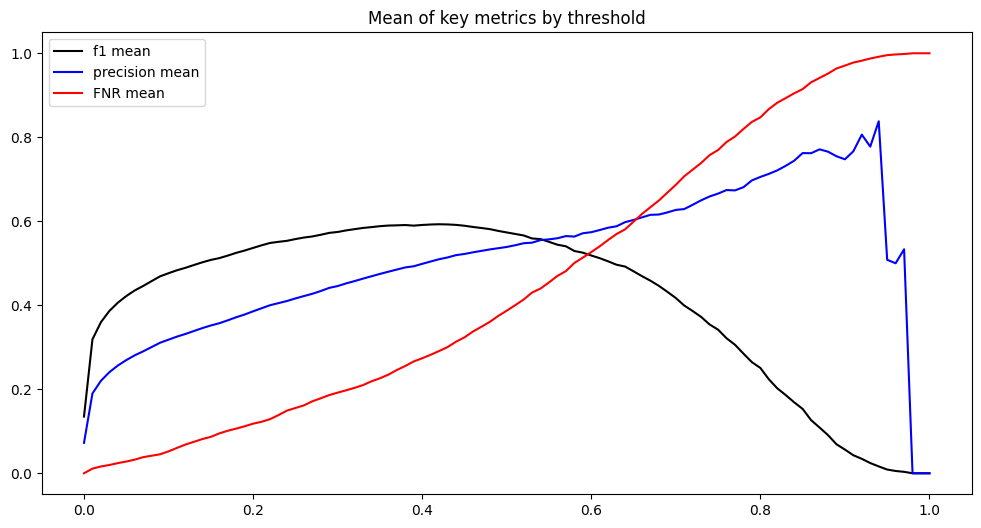

In [11]:
model_eval.create_visual()

In [11]:
model_eval.eval_metrics_

{'f1': np.float64(0.5734196112140129),
 'roc_auc': np.float64(0.948982689232318),
 'ap': np.float64(0.5609201150997091)}

Very strong model yet again. In comparison to xgboost, both the FNR and the precision increased faster, the f1 is higher on average. 